In [2]:
import numpy as np
import os
import sys 
import pandas as pd
import matplotlib.pyplot as plt

# Append paths to utility libraries 
sys.path.append('/Users/zacharykelly/Documents/MATLAB/projects/combiExperiments/code/lightLogger/miniSpect')
import MS_util 

sys.path.append('/Users/zacharykelly/Documents/MATLAB/projects/combiExperiments/code/lightLogger/camera')
import Camera_util
import recorder as r_world


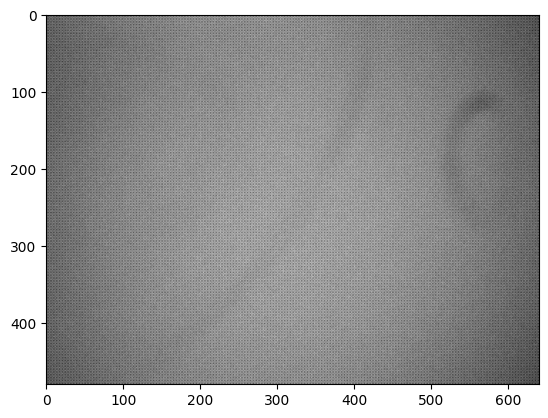

In [3]:
world_cam_view_test = '/Volumes/EXTERNAL1/together_15min_0x5hz/0x5_together_15min_world'

plt.imshow(np.load(os.path.join(world_cam_view_test, os.listdir(world_cam_view_test)[-3000])), cmap='gray')

plt.show()


In [4]:
# Define the path to the SSD holding all of the data
path_to_ssd: str = '/Volumes/EXTERNAL1'

In [5]:
# Experiment to analyze 
experiment_name: str = '5hz_real_15min'
frequency = 5
NDF = 1 

In [9]:
# Find the MS readings directory
MS_readings_dir: str = os.path.join(path_to_ssd, experiment_name, '0x5_real_15min_MS_readings')

In [ ]:
# Analyze the MS data
MS_util.plot_readings(MS_readings_dir)


In [10]:
# Gather the MS chip data frames to plot a single chip more in depthly 
AS_channel_df: pd.DataFrame = MS_util.reading_to_df(os.path.join(MS_readings_dir, 'AS_channels.csv'), np.uint16)
TS_channel_df: pd.DataFrame = MS_util.reading_to_df(os.path.join(MS_readings_dir, 'TS_channels.csv'), np.uint16)

In [ ]:
fig, axes = plt.subplots(2,1)



In [ ]:
# Find the world cam frame dir and the settings file
world_cam_dir: str = os.path.join(path_to_ssd, experiment_name, '0x01together_15min_world')
world_cam_settings_file: str = os.path.join(path_to_ssd, experiment_name, '0x01together_15min_world_settingsHistory.csv')

In [ ]:
import importlib
importlib.reload(Camera_util)
# Load in the world cam video 
world_cam_vid: np.ndarray = Camera_util.parse_mean_frame_array(world_cam_dir)


In [ ]:
# Fit the world cam source modulation
fig, ax = plt.subplots(1,1)

Camera_util.fit_source_modulation(world_cam_vid, NDF, frequency, ax)

In [ ]:
# Plot the camera settings history
world_cam_settings: pd.DataFrame = r_world.parse_settings_file(world_cam_settings_file)
world_cam_settings.head

fig, gain_ax = plt.subplots(1,1)
gain_ax.set_title('Settings History')

gain_ax.plot(world_cam_settings['gain_history'])
gain_ax.set_xlabel('Frame')
gain_ax.set_ylabel('Gain', color='blue')

exposure_ax = gain_ax.twinx()
exposure_ax.plot(world_cam_settings['exposure_history'], color='orange')
exposure_ax.set_ylabel('Exposure', color='orange')

plt.show()



In [ ]:
# Find the pupil cam frame directory
pupil_cam_dir: str = os.path.join(path_to_ssd, experiment_name, '0x01together_15min_pupil')

In [ ]:
import importlib
importlib.reload(Camera_util)
# Load in the pupil cam video 
pupil_vid: np.ndarray = Camera_util.parse_mean_frame_array(pupil_cam_dir)


In [ ]:
# Fit the pupil cam source modulation
fig, ax = plt.subplots(1,1)

Camera_util.fit_source_modulation(pupil_vid, NDF, frequency, ax, fps_guess=30)

In [ ]:
# Find the sunglasses reading file 
sunglasses_file: str = os.path.join(path_to_ssd, experiment_name, '0x5_together_15min_sunglasses.csv')

In [ ]:
# Load in the sunglasses file 
sunglasses_df: pd.DataFrame = pd.read_csv(sunglasses_file, header=None, names=['sensor_val'])
sunglasses_df.head

In [ ]:
fig, ax = plt.subplots(1,1)

ax.set_title('Sunglasses Sensor Val')
ax.plot(sunglasses_df['sensor_val'])
ax.set_xlabel('Measurement')
ax.set_ylabel('Sensor Val')

plt.show()